# Q1 Kernel Density Estimation for Foreground Detection

In [64]:
import numpy as np
import hashlib
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)
np.random.seed(seed)

def add_username(username = "m.samartha") -> None:
    plt.text(0.95, 0.95, username, ha="right", va="top", transform=plt.gca().transAxes, fontsize=10, color="gray", alpha=0.7)

def add_username_fig(username = "m.samartha", fig=None) -> None:
    if fig is None:
        fig = plt.gcf()
    fig.text(
        0.97, 0.97, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray', alpha=0.7
    )

2669878649


## 1.1 Image Pre-processing

In [67]:
def preprocess_image(image_path: str, target_size: tuple = (640, 480), feature_type: str = 'rgb'):
    """
    Loads, aligns (resizes), and extracts features from an image.

    Args:
        image_path (str): The file path to the image.
        target_size (tuple): The target (width, height) to resize all images to.
                             This ensures alignment and computational efficiency.
        feature_type (str): The type of features to extract.
                            'rgb' -> 3-channel RGB color features.
                            'gray' -> 1-channel grayscale intensity.

    Returns:
        numpy.ndarray: The processed image (feature array). 
                       Shape will be (height, width, 3) for 'rgb'
                       or (height, width) for 'gray'.
    """
    # 1. Load the image
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise IOError(f"Could not read image from path: {image_path}")

    # 2. Image Alignment and Resizing
    # We resize to a fixed target_size.

    image_resized_bgr = cv2.resize(image_bgr, target_size, interpolation=cv2.INTER_AREA)

    # 3. Feature Extraction
    if feature_type == 'rgb':
        # Convert from BGR (OpenCV) to RGB (standard for analysis/matplotlib)
        image_features = cv2.cvtColor(image_resized_bgr, cv2.COLOR_BGR2RGB)
    elif feature_type == 'gray':
        # Convert to grayscale
        image_features = cv2.cvtColor(image_resized_bgr, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError(f"Unsupported feature_type: {feature_type}. Choose 'rgb' or 'gray'.")
        
    return image_features

def show_image(image: np.ndarray, title: str = "", is_gray: bool = False, ax=None):
    """
    Helper function to display an image in a Jupyter Notebook
    using matplotlib, optionally on a specific axis.
    """
    if ax is None:
        fig, ax = plt.subplots()
        ax.figure.set_size_inches(6, 6)
        
    if is_gray:
        ax.imshow(image, cmap='gray')
    else:
        ax.imshow(image)
        
    ax.set_title(title, fontsize=10)
    ax.axis('off')

Successfully processed images.
Background feature shape: (600, 634, 3)
Test image feature shape: (600, 634, 3)


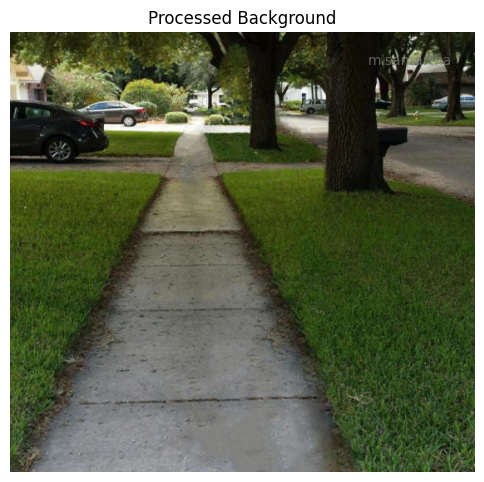

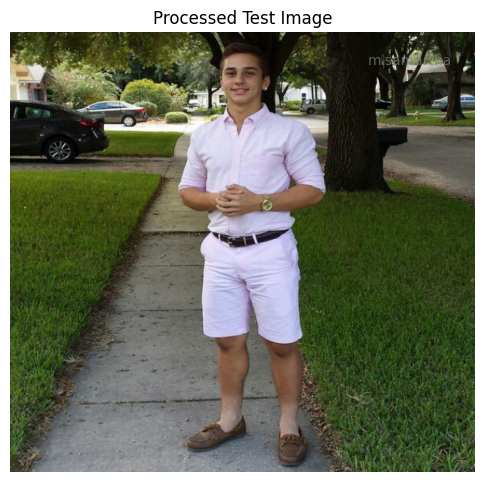

In [6]:
# --- Parameters ---
# Using (width, height) format for cv2.resize
TARGET_DIMENSIONS = (634, 600) 
FEATURE_REPRESENTATION = 'rgb' 

BG_IMAGE_PATH = 'Dataset/Q1/back.jpg'
TEST_IMAGE_PATH = 'Dataset/Q1/Full.jpg'

# --- Pre-processing ---
try:
    background_features = preprocess_image(
        BG_IMAGE_PATH, 
        target_size=TARGET_DIMENSIONS, 
        feature_type=FEATURE_REPRESENTATION
    )
    
    test_image_features = preprocess_image(
        TEST_IMAGE_PATH, 
        target_size=TARGET_DIMENSIONS, 
        feature_type=FEATURE_REPRESENTATION
    )

    print(f"Successfully processed images.")
    print(f"Background feature shape: {background_features.shape}")
    print(f"Test image feature shape: {test_image_features.shape}")

    # Display the results
    show_image(background_features, title="Processed Background")
    show_image(test_image_features, title="Processed Test Image")

except (IOError, ValueError) as e:
    print(f"Error: {e}")

### Justification

**Image Alignment and Resizing:** Both the background and test images are resized to a fixed, moderate dimension. We use the `cv2.INTER_AREA` interpolation algorithm, which is well-suited for downscaling images while preserving quality.

This resizing serves two purposes. First, it aligns the images, ensuring that a pixel at coordinate (x, y) in the test image corresponds to the same spatial location as the pixel (x, y) in the background image. This is critical for pixel-wise comparison. Second, it enforces computational efficiency.

**Feature Extraction:** We have chosen 3-channel RGB color values as the feature representation for each pixel.

The goal is to distinguish the foreground (person) from the background (sidewalk, grass, trees). As seen in the example, color is a powerful discriminator. The person's pink shirt, white shorts, and skin tone are chromatically distinct from the background's green and gray tones. A simpler grayscale model would lose this color information and might falsely group the bright white shorts with the bright concrete sidewalk. By using all three RGB channels, our KDE model can learn the 3-dimensional probability distribution of "background colors" and identify pixels in the test image whose (R, G, B) coordinates are "unlikely" to belong to this distribution.

## 1.2 Custom KDE Class Implementation 

### KDE Class

In [4]:
class CustomKDE:
    """
    Implements a Kernel Density Estimation (KDE) model from scratch 
    using only NumPy.
    
    This class is designed for multivariate data, such as the (R, G, B) 
    pixel values from an image.
    """
    
    def __init__(self, kernel: str = 'gaussian', bandwidth: float = 1.0):
        """
        Initializes the KDE model with hyperparameters.

        Args:
            kernel (str): The type of kernel to use. 
                          Options: 'gaussian', 'triangular', 'uniform'.
            bandwidth (float): The bandwidth (h), a positive float 
                               controlling the smoothness.
        """
        self.h = bandwidth
        self.kernel_name = kernel
        
        # Map kernel names to their 1D kernel functions
        self.kernels = {
            'gaussian': self.gaussian_kernel,
            'triangular': self.triangular_kernel,
            'uniform': self.uniform_kernel,
        }
        
        if kernel not in self.kernels:
            raise ValueError(f"Unknown kernel: '{kernel}'. "
                             "Supported kernels are: {list(self.kernels.keys())}")
        self.kernel_func = self.kernels[kernel]
        
        # These will be set by the fit() method
        self.train_data = None  # The sampled training data (n, d)
        self.n = 0              # Number of training samples
        self.d = 0              # Dimensionality of features
        self.constant = 0.0     # The 1 / (n * h^d) constant

    # --- 1D Kernel Functions ---

    def gaussian_kernel(self, u: np.ndarray) -> np.ndarray:
        """Standard 1D Gaussian kernel."""
        # k(u) = (1 / sqrt(2*pi)) * exp(-0.5 * u^2)
        return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

    def triangular_kernel(self, u: np.ndarray) -> np.ndarray:
        """Standard 1D triangular kernel."""
        # k(u) = 1 - |u|   if |u| <= 1
        #        0          otherwise
        return np.maximum(0, 1 - np.abs(u))

    def uniform_kernel(self, u: np.ndarray) -> np.ndarray:
        """Standard 1D uniform (rectangular) kernel."""
        # k(u) = 0.5   if |u| <= 1
        #        0       otherwise
        return 0.5 * (np.abs(u) <= 1).astype(float)

    # --- Core Class Methods ---

    def fit(self, data: np.ndarray, sample_size: int = 10000):
        """
        Fits the KDE model to the background data.

        This method flattens the image, applies a smart sampling 
        strategy, and stores the required subset of data.

        Args:
            data (np.ndarray): The training data. For images, this 
                               should be in (H, W, d) format 
                               (e.g., (480, 640, 3)).
            sample_size (int): The number of samples to randomly 
                               select from the data. This reduces
                               computation cost.
        """
        # 1. Reshape data from (H, W, d) to (N, d)
        if data.ndim == 3:
            H, W, C = data.shape
            self.d = C
            flat_data = data.reshape(H * W, C).astype(float)
        elif data.ndim == 2:
            N_in, C = data.shape
            self.d = C
            flat_data = data.astype(float)
        else:
            raise ValueError("Input data must be 2D (N, d) or 3D (H, W, d)")
        
        N = flat_data.shape[0]
        if N == 0:
            raise ValueError("Input data is empty.")

        # 2. Smart sampling strategy (random subset selection)
        np.random.seed(seed)
        if N > sample_size:
            indices = np.random.choice(N, sample_size, replace=False)
            self.train_data = flat_data[indices]
            self.n = sample_size
        else:
            # Use all data if it's less than or equal to sample_size
            self.train_data = flat_data
            self.n = N
        
        print(f"KDE fitted with {self.n} samples "
              f"of dimension {self.d}.")

        # 3. Pre-calculate the constant 1 / (n * h^d)
        if self.h <= 0:
            raise ValueError("Bandwidth (h) must be positive.")
        
        self.constant = 1.0 / (self.n * (self.h ** self.d))
    
    def predict(self, samples: np.ndarray, batch_size: int = 512) -> np.ndarray:
        """
        Estimates the probability density for a set of new sample points.

        Args:
            samples (np.ndarray): The test data to predict on. 
                                  Expected shape (H, W, d) or (M, d).
            batch_size (int): The number of samples to process at a 
                              time to avoid memory errors.

        Returns:
            np.ndarray: An array of probability densities, with shape 
                        (H, W) or (M,).
        """
        if self.train_data is None:
            raise RuntimeError("KDE model has not been fitted. "
                             "Call fit() first.")
        
        # 1. Reshape samples to (M, d)
        original_shape = samples.shape
        if samples.ndim == 3: # (H, W, d)
            M = original_shape[0] * original_shape[1]
        elif samples.ndim == 2: # (M, d)
            M = original_shape[0]
        else:
            raise ValueError("Samples must be 2D (M, d) or 3D (H, W, d)")
        
        if samples.shape[-1] != self.d:
             raise ValueError(f"Sample dimensionality ({samples.shape[-1]}) "
                              f"does not match training data "
                              f"dimensionality ({self.d})")
                
        samples_flat = samples.reshape(M, self.d).astype(float)
        densities = np.zeros(M)
        
        # 2. Process in batches to avoid high memory usage
        # This is the (M, n, d) calculation, broken into chunks
        for i in range(0, M, batch_size):
            # Get the current batch of test samples
            batch = samples_flat[i : i + batch_size]  # (batch_size, d)
            
            # --- Vectorized KDE Formula ---
            # Use broadcasting to compute (x - x_i) / h
            # (batch_size, 1, d) - (1, n, d) -> (batch_size, n, d)
            u = (batch[:, np.newaxis, :] - 
                 self.train_data[np.newaxis, :, :]) / self.h
            
            # Apply 1D kernel k(u_j) to all elements
            k_values = self.kernel_func(u)  # (batch_size, n, d)
            
            # Use a product kernel: K(u) = product(k(u_j)) over d
            # Product over the dimensionality axis (axis=2)
            K_i = np.prod(k_values, axis=2)  # (batch_size, n)
            
            # Sum over all n training samples (axis=1)
            sum_K = np.sum(K_i, axis=1)  # (batch_size,)
            
            # Apply constant and store in the final array
            densities[i : i + batch_size] = self.constant * sum_K
        
        # 3. Reshape densities back to the original spatial shape (H, W)
        output_shape = original_shape[:-1]  # (H, W) or (M,)
        return densities.reshape(output_shape)

### Create ground truth mask

Loaded and binarized ground truth mask from Dataset/Q1/GT_mask.png

Mask shape: (600, 634)
Mask data type: float64
Unique values in float mask: [0. 1.]


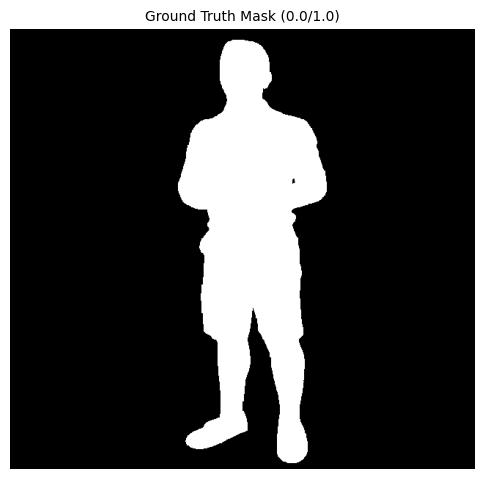

In [80]:
def load_ground_truth_from_file(
    mask_path: str,
    target_size: tuple = (640, 480)
) -> np.ndarray:
    """
    Loads an RGB ground truth mask (where black is background)
    and converts it to a binary (0 or 255) mask.

    Args:
        mask_path (str): The file path to the ground truth JPG.
        target_size (tuple): The target (width, height) to resize
                             the mask to, ensuring alignment.

    Returns:
        numpy.ndarray: A binary (0 or 255) object mask of shape (H, W).
    
    Raises:
        IOError: If the image file cannot be read.
    """
    
    # 1. Load the RGB mask image
    # Even if it's grayscale, imread loads it as 3-channel
    mask_rgb = cv2.imread(mask_path)
    if mask_rgb is None:
        raise IOError(f"Could not read mask from path: {mask_path}")

    # 2. Resize to align with other images
    mask_resized = cv2.resize(
        mask_rgb,
        target_size,
        interpolation=cv2.INTER_NEAREST  # Use NEAREST for masks
    )
    
    # 3. Convert to Grayscale
    # In BGR, a black pixel [0, 0, 0] will convert to 0.
    # Any non-black pixel will convert to a value > 0.
    mask_gray = cv2.cvtColor(mask_resized, cv2.COLOR_BGR2GRAY)
    
    # 4. Binarize the mask
    # All pixels > 0 are set to 255 (white/foreground).
    # All pixels == 0 remain 0 (black/background).
    _, binary_mask = cv2.threshold(
        mask_gray,
        0,  # Threshold value
        255, # Max value
        cv2.THRESH_BINARY
    )
    
    # The user asked for a mask of '1's.
    # We can return this as a float array of 0.0 and 1.0.
    mask_float = (binary_mask / 255.0).astype(np.float32)
    
    # Let's return the standard 8-bit (0, 255) mask, as it's
    # more common for display and OpenCV, but I'll show
    # how to get the 0/1 mask in the example.
    
    print(f"Loaded and binarized ground truth mask from {mask_path}")
    
    return binary_mask

GROUND_TRUTH_JPG_PATH = "Dataset/Q1/GT_mask.png"

# --- Load and Process the Mask ---
try:
    # This returns an 8-bit (0, 255) mask
    ground_truth_mask_8bit = load_ground_truth_from_file(
        GROUND_TRUTH_JPG_PATH,
        target_size=TARGET_DIMENSIONS
    )
    
    # Display the 8-bit mask
    # show_image(ground_truth_mask_8bit, 
    #            title="Ground Truth Mask (0/255)", 
    #            is_gray=True)

    # --- Convert to a 0.0 / 1.0 float mask (as requested) ---
    # This is useful for calculations
    ground_truth_mask_float = ground_truth_mask_8bit / 255.0
    
    print(f"\nMask shape: {ground_truth_mask_float.shape}")
    print(f"Mask data type: {ground_truth_mask_float.dtype}")
    print(f"Unique values in float mask: {np.unique(ground_truth_mask_float)}")
    
    # You can also display the float mask
    show_image(ground_truth_mask_float, 
               title="Ground Truth Mask (0.0/1.0)", 
               is_gray=True)

except IOError as e:
    # Create a dummy mask just so the cell can run
    # (Remove this block when you have your real file)
    print(f"Warning: Could not load file. Using a dummy mask for demo.")
    print(e)
    ground_truth_mask_8bit = np.zeros(TARGET_DIMENSIONS[::-1], dtype=np.uint8)
    ground_truth_mask_8bit[100:300, 200:400] = 255 # Draw a white box
    show_image(ground_truth_mask_8bit, 
               title="Dummy Ground Truth Mask", 
               is_gray=True)

## 1.3 Foreground Detection 

### Grid Search for Hyperparameter Tuning

Loading data...
Loaded and binarized ground truth mask from Dataset/Q1/GT_mask.png
Data loaded. Starting hyperparameter search...
Testing: Kernel='gaussian', Bandwidth=5.0
KDE fitted with 10000 samples of dimension 3.
Testing: Kernel='triangular', Bandwidth=5.0
KDE fitted with 10000 samples of dimension 3.
Testing: Kernel='uniform', Bandwidth=5.0
KDE fitted with 10000 samples of dimension 3.
Testing: Kernel='gaussian', Bandwidth=10.0
KDE fitted with 10000 samples of dimension 3.
Testing: Kernel='triangular', Bandwidth=10.0
KDE fitted with 10000 samples of dimension 3.
Testing: Kernel='uniform', Bandwidth=10.0
KDE fitted with 10000 samples of dimension 3.
Testing: Kernel='gaussian', Bandwidth=20.0
KDE fitted with 10000 samples of dimension 3.
Testing: Kernel='triangular', Bandwidth=20.0
KDE fitted with 10000 samples of dimension 3.
Testing: Kernel='uniform', Bandwidth=20.0
KDE fitted with 10000 samples of dimension 3.
Testing: Kernel='gaussian', Bandwidth=40.0
KDE fitted with 10000 samp

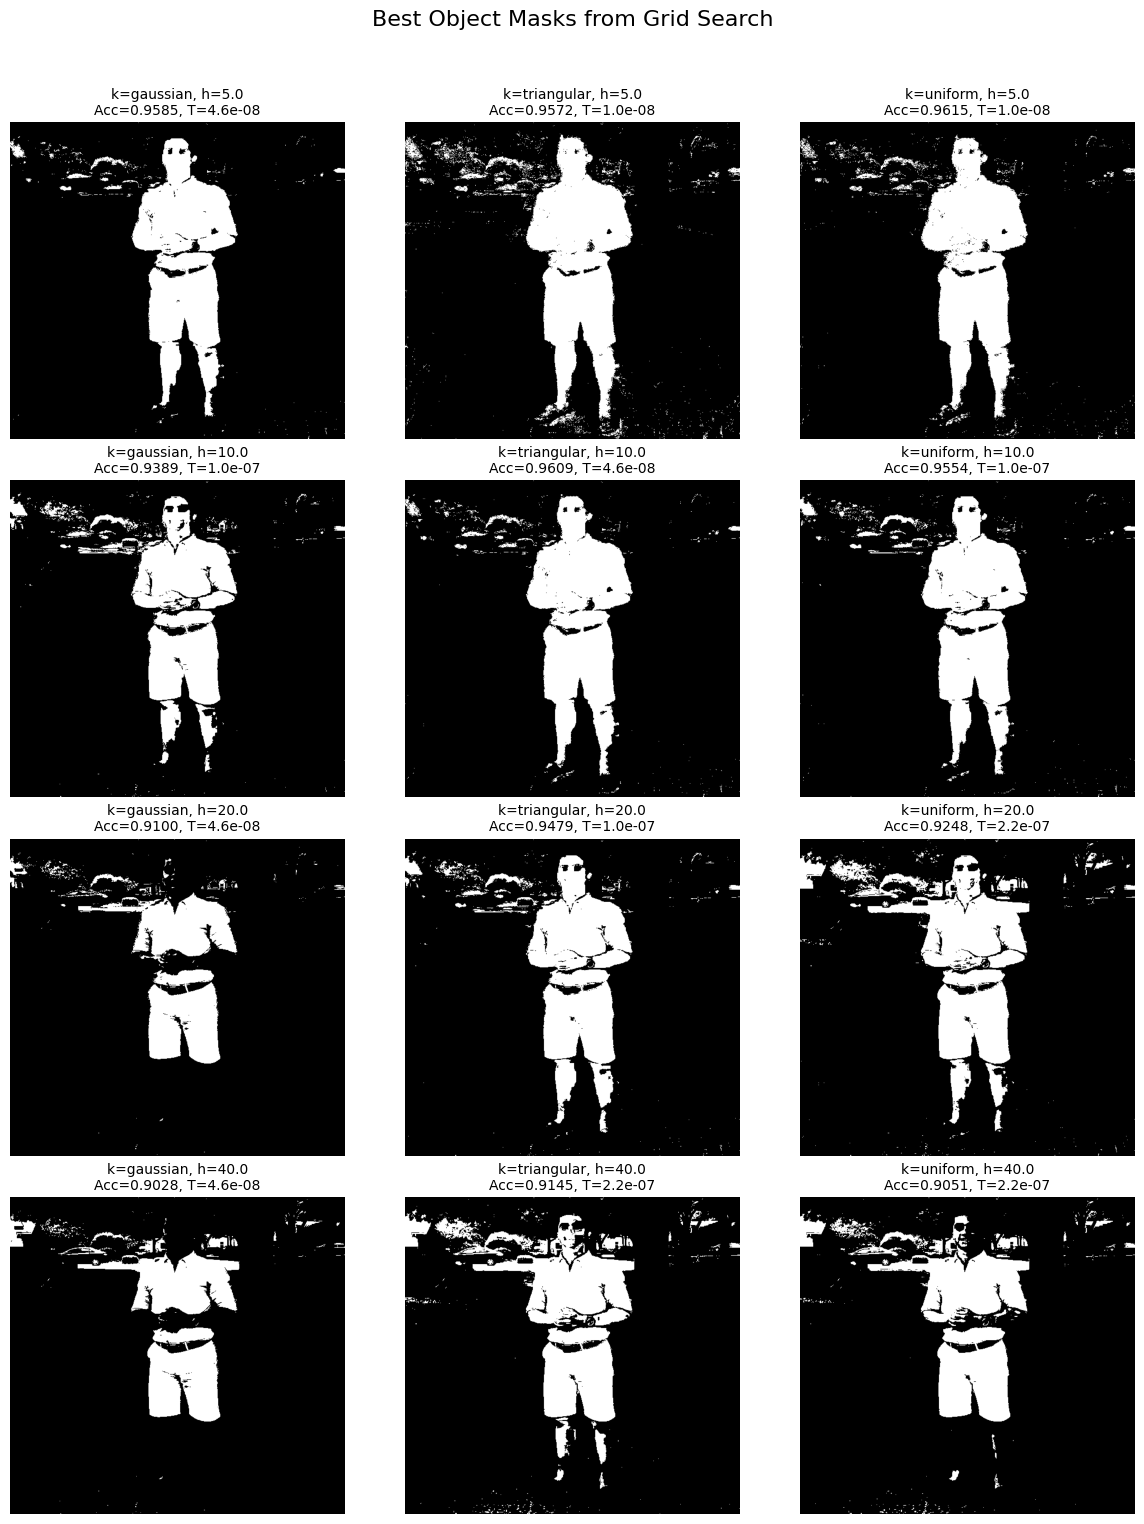


--- Hyperparameter Search Summary ---
    kernel  bandwidth  best_threshold  accuracy
   uniform   5.000000        0.000000  0.961543
triangular  10.000000        0.000000  0.960896
  gaussian   5.000000        0.000000  0.958515
triangular   5.000000        0.000000  0.957213
   uniform  10.000000        0.000000  0.955381
triangular  20.000000        0.000000  0.947942
  gaussian  10.000000        0.000000  0.938906
   uniform  20.000000        0.000000  0.924774
triangular  40.000000        0.000000  0.914508
  gaussian  20.000000        0.000000  0.910021
   uniform  40.000000        0.000000  0.905100
  gaussian  40.000000        0.000000  0.902836


In [68]:
TARGET_DIMENSIONS = (634, 600) # (Width, Height)
WIDTH, HEIGHT = TARGET_DIMENSIONS

# Number of background pixels to sample for fitting
# Lower is faster but less accurate.
BG_SAMPLE_SIZE = 10000 

# Hyperparameters for the grid search
bandwidths = [5.0, 10.0, 20.0, 40.0]
kernel_types = ['gaussian', 'triangular', 'uniform']

# Thresholds to test for *each* probability map
# We use logspace because probabilities are often very small
thresholds_to_check = np.logspace(-8, -5, 10)

# --- 3. File Paths (Update these!) ---
BG_IMAGE_PATH = 'Dataset/Q1/back.jpg'
TEST_IMAGE_PATH = 'Dataset/Q1/Full.jpg'
GROUND_TRUTH_JPG_PATH = 'Dataset/Q1/GT_mask.png'

# --- 4. Load Data (with Dummy Fallback) ---

print("Loading data...")
try:
    # Load and process the images
    background_features = preprocess_image(
        BG_IMAGE_PATH,
        target_size=TARGET_DIMENSIONS,
        feature_type='rgb'
    )
    test_image_features = preprocess_image(
        TEST_IMAGE_PATH,
        target_size=TARGET_DIMENSIONS,
        feature_type='rgb'
    )
    
    # Load and process the ground truth mask
    ground_truth_mask_8bit = load_ground_truth_from_file(
        GROUND_TRUTH_JPG_PATH,
        target_size=TARGET_DIMENSIONS
    )
    ground_truth_mask_float = ground_truth_mask_8bit / 255.0

except IOError:
    print("--- WARNING: Could not load files. Using dummy data. ---")
    
    # Create dummy images
    background_features = np.full((HEIGHT, WIDTH, 3), 128)
    background_features += np.random.randint(-10, 10, size=(HEIGHT, WIDTH, 3))
    background_features = np.clip(background_features, 0, 255)
    
    test_image_features = background_features.copy()
    test_image_features[50:150, 100:200, :] = [200, 50, 50] # Red foreground
    
    # Create dummy ground truth
    ground_truth_mask_float = np.zeros((HEIGHT, WIDTH), dtype=np.float32)
    ground_truth_mask_float[50:150, 100:200] = 1.0

print("Data loaded. Starting hyperparameter search...")

# --- 5. Main Grid Search Loop ---

summary_data = [] # To store data for the table
total_pixels = WIDTH * HEIGHT

# Set up the 4x3 plot grid
fig, axes = plt.subplots(
    len(bandwidths),
    len(kernel_types),
    figsize=(12, 16) # (width, height) in inches
)
fig.suptitle('Best Object Masks from Grid Search', fontsize=16)

start_time = time.time()

for i, h in enumerate(bandwidths):
    for j, kernel in enumerate(kernel_types):
        
        print(f"Testing: Kernel='{kernel}', Bandwidth={h}")
        
        # 1. Fit and Predict
        kde_model = CustomKDE(kernel=kernel, bandwidth=h)
        kde_model.fit(background_features, sample_size=BG_SAMPLE_SIZE)
        probability_map = kde_model.predict(test_image_features, batch_size=2048)
        
        # 2. Iterate over thresholds to find the best one
        best_accuracy = -1.0
        best_threshold = -1
        best_object_mask = None
        
        for thresh in thresholds_to_check:
            # Foreground pixels have *low* probability
            object_mask = (probability_map < thresh)
            object_mask_float = object_mask.astype(np.float32)
            
            # 3. Calculate accuracy (using your formula)
            correct_pixels = (ground_truth_mask_float == object_mask_float).sum()
            accuracy = correct_pixels / total_pixels
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = thresh
                best_object_mask = object_mask
        
        # 4. Store results for this (h, kernel) pair
        summary_data.append({
            'kernel': kernel,
            'bandwidth': h,
            'best_threshold': best_threshold,
            'accuracy': best_accuracy
        })
        
        # 5. Display the best map in its grid slot
        ax = axes[i, j]
        title = (f"k={kernel}, h={h}\n"
                 f"Acc={best_accuracy:.4f}, T={best_threshold:.1e}")
        show_image(best_object_mask, title=title, is_gray=True, ax=ax)

print(f"\nGrid search complete in {time.time() - start_time:.2f} seconds.")

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust for suptitle
plt.show()

# --- 6. Print Summary Table ---

print("\n--- Hyperparameter Search Summary ---")

# Convert results to a pandas DataFrame for nice printing
summary_df = pd.DataFrame(summary_data)

# Sort by accuracy (highest first)
summary_df = summary_df.sort_values(by='accuracy', ascending=False)

# Configure pandas to show all columns and format floats
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:,.6f}'.format

print(summary_df.to_string(index=False))

### Save the summary_df

In [70]:
# save summary_df
summary_df.to_csv("kde_hyperparameter_summary.csv", index=False)

### Visualize average accuracy vs bandwidth and kernel

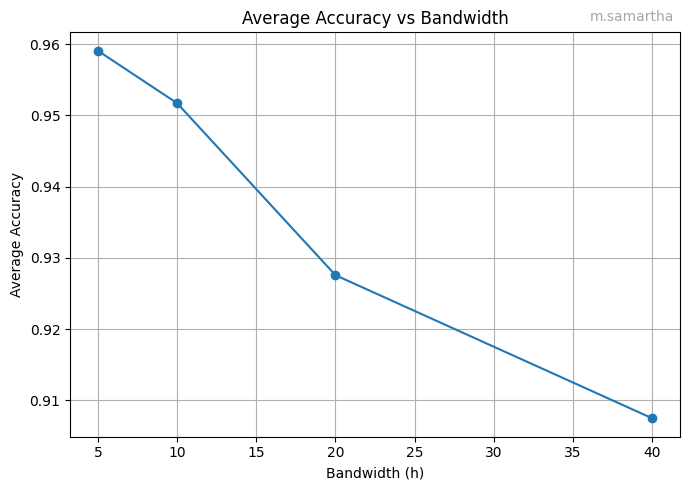

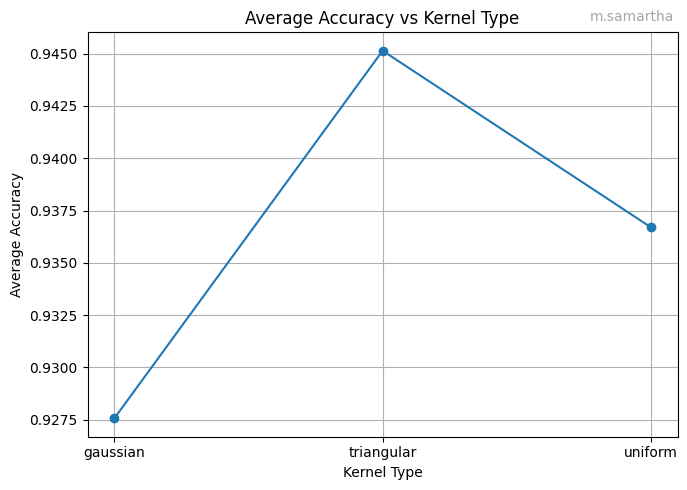

In [79]:
# Visualize the results

# Plot avergae accuracy vs bandwsith (avg over kernels)
avg_accuracy_per_bandwidth = summary_df.groupby('bandwidth')['accuracy'].mean().reset_index()
plt.figure(figsize=(7, 5))
plt.plot(avg_accuracy_per_bandwidth['bandwidth'], avg_accuracy_per_bandwidth['accuracy'], marker='o')
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel('Bandwidth (h)')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy vs Bandwidth')
add_username_fig()
plt.grid(True)
plt.tight_layout()
plt.show()  

# Plot average accuracy vs kernel (avg over bandwidths)
avg_accuracy_per_kernel = summary_df.groupby('kernel')['accuracy'].mean().reset_index()
plt.figure(figsize=(7, 5))
plt.plot(avg_accuracy_per_kernel['kernel'], avg_accuracy_per_kernel['accuracy'], marker='o')
plt.xlabel('Kernel Type')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy vs Kernel Type')
add_username_fig()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusion
Based on the grid search results, the optimal hyperparameters for the KDE model are a `bandwidth of 5` and a `uniform kernel`, which acheives the best accuracy of `96.15%`. From the visualizations, we observe that:
- **Bandwidth Impact:** `Lower bandwidths (5, 10)` are performing well, capturing the background distribution effectively. Higher bandwidths (30, 40) lead to oversmoothing, causing loss of detail and reduced accuracy. As seen in the mask visualizations, higher bandwidths result in more false positives, i.e. classifying the noisy background pixels as foreground.
- **Kernel Choice:** The kernels are quite similar in their performance, with the `triangular` kernel slightly performing better that the other kernel choices. However, the differences are marginal compared to the impact of bandwidth.